In [60]:
import pandas as pd

df = pd.read_csv(
    "B Corp Impact Data.csv",
    low_memory=False,
    dtype=str      # 일단 전부 문자열로
).replace({"": None})

# 날짜 컬럼 파싱
date_cols = ["date_first_certified", "date_certified"]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce", format="%Y.%m.%d")

# 스코어 계열 숫자화
score_cols = ["overall_score",
              "impact_area_community", "impact_area_customers",
              "impact_area_environment", "impact_area_governance",
              "impact_area_workers"]
df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")


In [61]:
# 최신 회차만 남김
df_latest = (
    df.sort_values(["company_id", "certification_cycle"], ascending=[True, False])
      .drop_duplicates("company_id", keep="first")
)


In [62]:
today = pd.Timestamp("2025-06-21")

def active(row):
    if row["current_status"].strip().lower() != "certified":
        return 0
    # 인증일 + 3년 주기(보통) → 아직 유효?
    expiry = row["date_certified"] + pd.DateOffset(years=3)
    return int(expiry >= today)

df_latest["is_active_bcorp"] = df_latest.apply(active, axis=1)


In [63]:
import numpy as np, skfuzzy as fuzz

# 우주집합 정의
u_overall = np.arange(0, 201, 1)
u_area    = np.arange(0, 41, 1)

def trim(a,b,c,u): return fuzz.trimf(u,[a,b,c])

MF = {                         # 총 8×3 = 24개 함수
    "overall_low" : trim(0,0,80,u_overall),
    "overall_mid" : trim(60,100,140,u_overall),
    "overall_high": trim(100,200,200,u_overall)
}
for area in ["community","customers","environment","governance","workers"]:
    MF[f"{area}_low"]  = trim(0,0,20,u_area)
    MF[f"{area}_mid"]  = trim(10,20,30,u_area)
    MF[f"{area}_high"] = trim(20,40,40,u_area)

def μ(val, name):
    u = u_overall if name.startswith("overall") else u_area
    return fuzz.interp_membership(u, MF[name], val)

def fuzzify_row(r):
    res = {}
    res["overall_low"]  = μ(r["overall_score"],  "overall_low")
    res["overall_mid"]  = μ(r["overall_score"],  "overall_mid")
    res["overall_high"] = μ(r["overall_score"],  "overall_high")
    for area in ["community","customers","environment","governance","workers"]:
        v = r[f"impact_area_{area}"]
        for lvl in ["low","mid","high"]:
            res[f"{area}_{lvl}"] = μ(v, f"{area}_{lvl}")
    return pd.Series(res)

fuzzy_feats = df_latest.apply(fuzzify_row, axis=1)
X = fuzzy_feats.values
y = df_latest["is_active_bcorp"].values


In [64]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=3)

clf = XGBClassifier(
    max_depth=3, n_estimators=300,
    learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
    eval_metric="auc"
).fit(X_train, y_train)

print("AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
# 중요 피처
importances = pd.Series(clf.feature_importances_, index=fuzzy_feats.columns)\
              .sort_values(ascending=False).head(15)
print(importances)


AUC: 0.8302128837091843
governance_mid     0.417351
customers_low      0.157757
governance_low     0.112430
community_low      0.045231
workers_low        0.039911
community_mid      0.029344
workers_high       0.025658
community_high     0.024288
environment_low    0.021029
workers_mid        0.018270
environment_mid    0.017388
customers_high     0.017133
overall_mid        0.016884
customers_mid      0.015768
governance_high    0.015206
dtype: float32


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

desc = df_latest["description"].fillna("").str.replace("\n"," ")
vec  = TfidfVectorizer(ngram_range=(1,2), max_features=5000,
                       stop_words="english")
logit = LogisticRegression(max_iter=200, class_weight="balanced")

pipe = make_pipeline(vec, logit).fit(desc, y)
print(classification_report(y, pipe.predict(desc)))

# 상위 양(+) 계수 단어
coef = logit.coef_[0]
terms = vec.get_feature_names_out()
top_pos = pd.Series(coef, index=terms).sort_values(ascending=False).head(30)
top_neg = pd.Series(coef, index=terms).sort_values().head(30)
print("Keep-side words:\n", top_pos)
print("Drop-side words:\n", top_neg)


              precision    recall  f1-score   support

           0       0.84      0.76      0.80      6779
           1       0.74      0.82      0.78      5487

    accuracy                           0.79     12266
   macro avg       0.79      0.79      0.79     12266
weighted avg       0.79      0.79      0.79     12266

Keep-side words:
 uk                2.447451
ensuring          2.424168
bespoke           2.378735
specialising      2.276574
2023              2.188990
tailored          2.142108
fostering         1.994221
future            1.916401
enhance           1.777156
brand             1.746133
specialist        1.734540
bristol           1.692456
ai                1.686643
enabling          1.666073
expertise         1.626148
commitment        1.625355
excellence        1.610384
team              1.604078
corp certified    1.600655
london            1.597538
driven            1.585194
ve                1.577635
architects        1.572317
europe            1.518673
founded

In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
from xgboost import XGBClassifier

kf   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = []

for tr_idx, te_idx in kf.split(X, y):
    X_tr, X_te = X[tr_idx], X[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    clf = XGBClassifier(
        max_depth=3, n_estimators=300,
        learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        eval_metric="auc"
    ).fit(X_tr, y_tr)

    proba = clf.predict_proba(X_te)[:, 1]
    aucs.append(roc_auc_score(y_te, proba))

print("Fold AUCs:", np.round(aucs, 3))
print(f"Mean ± SD : {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")


Fold AUCs: [0.838 0.839 0.845 0.83  0.825]
Mean ± SD : 0.835 ± 0.007


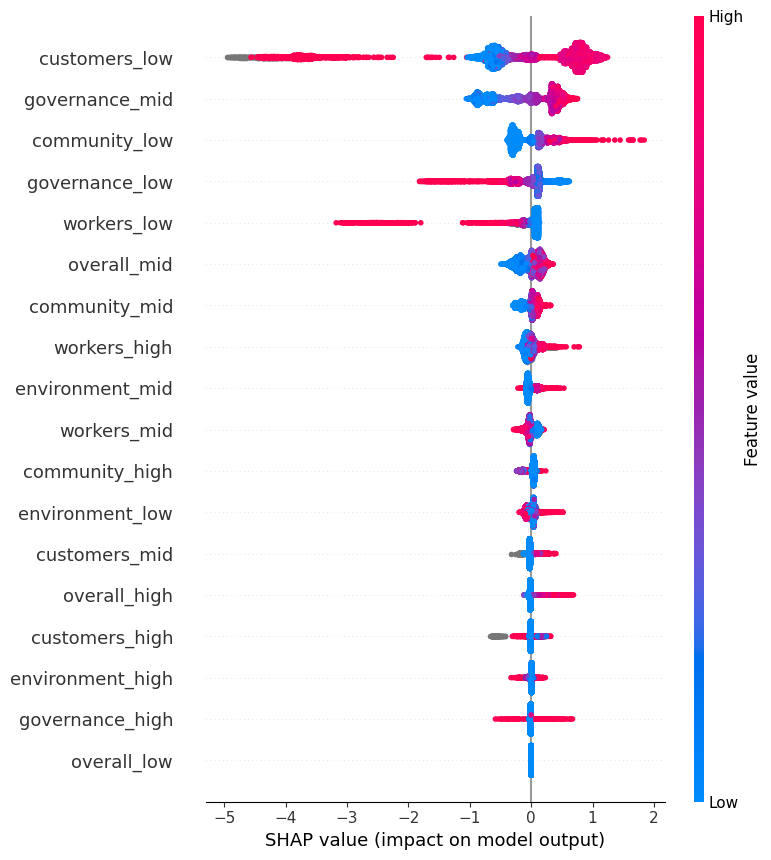

In [67]:
import shap

# 학습 완료된 clf 사용
explainer = shap.TreeExplainer(clf)
shap_vals = explainer.shap_values(X)          # X: 전체 또는 관심 subset

# 2-A 전체 요약
shap.summary_plot(shap_vals, X, feature_names=fuzzy_feats.columns)


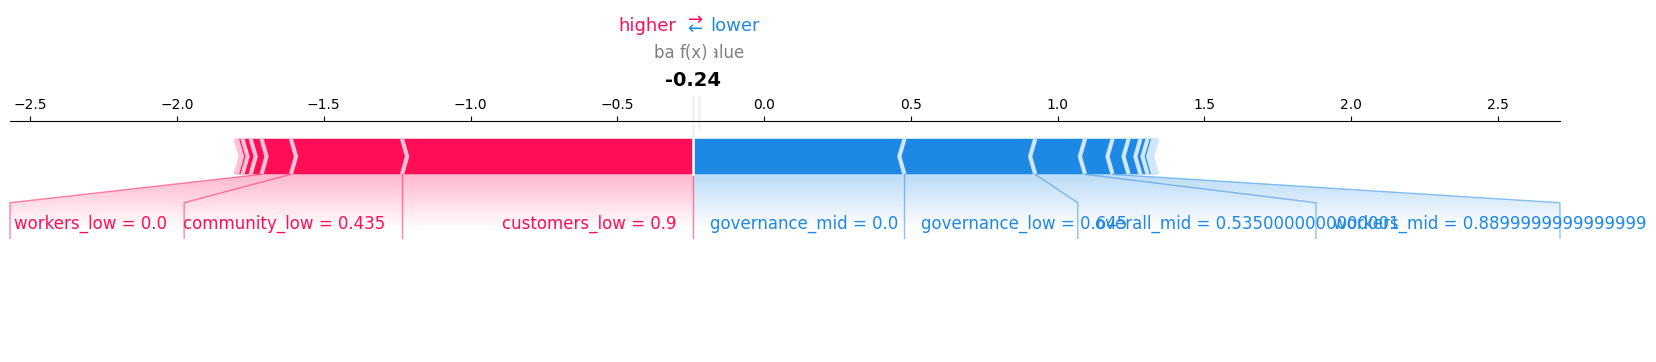

In [68]:
# 한 번만 실행
df_latest = df_latest.set_index("company_id", drop=False)

idx = df_latest.index.get_loc("0013b00001rId9LAAS")   # ← 이제 정상
shap.force_plot(
    explainer.expected_value,
    shap_vals[idx],
    X[idx],
    feature_names=fuzzy_feats.columns,
    matplotlib=True
)


In [69]:
!pip install matplotlib

# Re-Traditional

In [70]:
import pandas as pd, numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

### 1) 피처: 원점수 6개만 사용
raw_cols = [
    "overall_score",
    "impact_area_community", "impact_area_customers",
    "impact_area_environment", "impact_area_governance",
    "impact_area_workers"
]
X_raw = df_latest[raw_cols].fillna(0).values          # NaN → 0
y      = df_latest["is_active_bcorp"].values

### 2) 간단 파이프라인: (표준화) → XGBoost
clf_raw = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        max_depth=3, n_estimators=300,
        learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        eval_metric="auc"
    )
)

### 3) 5-Fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs_raw = []

for tr, te in cv.split(X_raw, y):
    clf_raw.fit(X_raw[tr], y[tr])
    p = clf_raw.predict_proba(X_raw[te])[:, 1]
    aucs_raw.append(roc_auc_score(y[te], p))

print("Raw-score CV AUCs :", np.round(aucs_raw, 3))
print("Mean ± SD :", np.mean(aucs_raw).round(3), "±", np.std(aucs_raw).round(3))

### 4) 한 번 학습 → 리포트
X_tr, X_te, y_tr, y_te = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=3
)
clf_raw.fit(X_tr, y_tr)
print(classification_report(y_te, clf_raw.predict(X_te)))



Raw-score CV AUCs : [0.836 0.837 0.844 0.829 0.828]
Mean ± SD : 0.835 ± 0.006
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1356
           1       0.71      0.78      0.74      1098

    accuracy                           0.76      2454
   macro avg       0.76      0.76      0.76      2454
weighted avg       0.76      0.76      0.76      2454



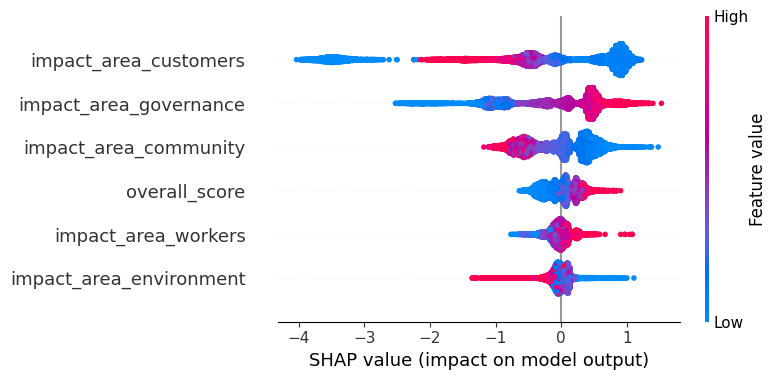

In [71]:
import shap
expl = shap.TreeExplainer(clf_raw.named_steps["xgbclassifier"])
shap_vals_raw = expl.shap_values(
    clf_raw.named_steps["standardscaler"].transform(X_raw)
)
shap.summary_plot(
    shap_vals_raw, features=X_raw,
    feature_names=raw_cols, show=True  # show=True → 바로 그림
)


# Belongs to B-Corp를 FuzzySet으로

In [72]:
# ─────────────────────────────────────────────────────────────
# 0. 준비: 라이브러리 로딩 ─ 반자동 install 구문 포함
# ─────────────────────────────────────────────────────────────
import sys, subprocess

def pip_if_missing(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for p in ["pandas", "numpy", "scikit-learn", "xgboost", "skfuzzy"]:
    pip_if_missing(p)

import pandas as pd
import numpy as np
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

# ─────────────────────────────────────────────────────────────
# 1. 데이터 읽기 & 기본 전처리
# ─────────────────────────────────────────────────────────────
CSV_PATH = "B Corp Impact Data.csv"   # ← 본인 경로로 수정
df = pd.read_csv(CSV_PATH, low_memory=False, dtype=str).replace({"": None})

# 날짜 파싱 (필요 시)
for c in ["date_certified"]:
    df[c] = pd.to_datetime(df[c], errors="coerce", format="%Y.%m.%d")

# 숫자형 캐스팅
score_cols = ["overall_score",
              "impact_area_community", "impact_area_customers",
              "impact_area_environment", "impact_area_governance",
              "impact_area_workers"]
df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")

# 라벨 생성: active B-Corp(1) vs inactive(0)
today = pd.Timestamp("2025-06-21")
def is_active(row):
    if str(row["current_status"]).lower() != "certified":
        return 0
    expiry = row["date_certified"] + pd.DateOffset(years=3)
    return int(expiry >= today)
df["is_active_bcorp"] = df.apply(is_active, axis=1)

# ─────────────────────────────────────────────────────────────
# 2. 퍼지 멤버십 피처 생성 (Low·Mid·High → 총 18개)
# ─────────────────────────────────────────────────────────────
u_overall = np.arange(0, 201, 1)
u_area    = np.arange(0, 41, 1)

def trim(a, b, c, u): return fuzz.trimf(u, [a, b, c])

MF = {
    "overall_low":  trim(0,   0,   80,  u_overall),
    "overall_mid":  trim(60,  100, 140, u_overall),
    "overall_high": trim(100, 200, 200, u_overall)
}
for area in ["community", "customers", "environment", "governance", "workers"]:
    MF[f"{area}_low"]  = trim(0,  0,  20, u_area)
    MF[f"{area}_mid"]  = trim(10, 20, 30, u_area)
    MF[f"{area}_high"] = trim(20, 40, 40, u_area)

def μ(val, name):
    u = u_overall if "overall" in name else u_area
    return fuzz.interp_membership(u, MF[name], val)

def fuzzify_row(r):
    out = {}
    out["overall_low"]  = μ(r["overall_score"], "overall_low")
    out["overall_mid"]  = μ(r["overall_score"], "overall_mid")
    out["overall_high"] = μ(r["overall_score"], "overall_high")
    for area in ["community","customers","environment","governance","workers"]:
        v = r[f"impact_area_{area}"]
        for lvl in ["low","mid","high"]:
            out[f"{area}_{lvl}"] = μ(v, f"{area}_{lvl}")
    return pd.Series(out)

fuzzy_feats = df.apply(fuzzify_row, axis=1)

# ─────────────────────────────────────────────────────────────
# 3. XGBoost 학습 → 확률 예측
# ─────────────────────────────────────────────────────────────
X = fuzzy_feats.values
y = df["is_active_bcorp"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

clf = XGBClassifier(
    max_depth=3, n_estimators=300, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, eval_metric="auc"
).fit(X_train, y_train)

print("Hold-out AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
print(classification_report(y_test, clf.predict(X_test)))

# ─────────────────────────────────────────────────────────────
# 4. 확률 → 퍼지 membership(0~1) 매핑
# ─────────────────────────────────────────────────────────────
proba = clf.predict_proba(X)[:, 1]

# S-curve 매핑: 경계 0.5 기준, 경사 12 → 필요 시 조정
membership = 1 / (1 + np.exp(-12 * (proba - 0.5)))

df["bcorp_membership"] = membership

# 간단 등급 부여
def grade(m):
    if m < 0.25:        return "Drop-risk"
    elif m < 0.5:       return "Borderline"
    elif m < 0.75:      return "Stable"
    else:               return "Exemplar"

df["bcorp_grade"] = df["bcorp_membership"].apply(grade)

# ─────────────────────────────────────────────────────────────
# 5. 결과 저장 or 확인
# ─────────────────────────────────────────────────────────────
df[["company_id", "company_name", "bcorp_membership", "bcorp_grade"]+score_cols]\
  .to_csv("bcorp_membership_scored.csv", index=False)

print("\n샘플 10개:")
print(df[["company_name", "bcorp_membership", "bcorp_grade"]].head(10))


Hold-out AUC: 0.8225937251537185
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      2098
           1       0.68      0.77      0.72      1651

    accuracy                           0.74      3749
   macro avg       0.74      0.74      0.74      3749
weighted avg       0.75      0.74      0.74      3749


샘플 10개:
                      company_name  bcorp_membership bcorp_grade
0  Arch Textiles Manufacture Corp.          0.482329  Borderline
1  Arch Textiles Manufacture Corp.          0.394870  Borderline
2                             kria          0.539430      Stable
3                             kria          0.724981      Stable
4                     Ocean Design          0.902794    Exemplar
5                   Reflect Studio          0.224792   Drop-risk
6                   Reflect Studio          0.014282   Drop-risk
7                  sString Limited          0.877474    Exemplar
8                   Collectiv Food          0.

In [73]:
"""
B-Corp certification “continuity score” in [0, 1]

• keep_prob   : model probability that the company will KEEP its certificate
• keep_score  : same probability passed through an S-curve (fuzzy membership)

Input  :  csv_path  – B-Corp Impact Data CSV (original field names)
Output :  bc_continuous.csv  (adds the two columns)
"""

# ──────────────────────────────
# 0. pip-install once if needed
# ──────────────────────────────
# !pip install pandas numpy scikit-learn xgboost

import pandas as pd, numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

csv_path = "B Corp Impact Data.csv"            # ○ 수정
out_path = "bc_continuous.csv"                 # ○ 수정

# ──────────────────────────────
# 1. load & minimal cleanup
# ──────────────────────────────
df = pd.read_csv(csv_path, low_memory=False, dtype=str).replace({"": None})

score_cols = [
    "overall_score",
    "impact_area_community", "impact_area_customers",
    "impact_area_environment", "impact_area_governance",
    "impact_area_workers"
]
df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")

# label: 1 = still certified, 0 = lost/expired
today = pd.Timestamp("2025-06-21")
df["date_certified"] = pd.to_datetime(df["date_certified"], errors="coerce", format="%Y.%m.%d")

def active(row):
    if str(row["current_status"]).lower() != "certified":
        return 0
    return int(row["date_certified"] + pd.DateOffset(years=3) >= today)

df["is_active"] = df.apply(active, axis=1)

# ──────────────────────────────
# 2. train simple XGBoost on raw scores
# ──────────────────────────────
X = df[score_cols].values
y = df["is_active"].values

# quick 80-20 split; seed fixed for reproducibility
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

clf = XGBClassifier(
    max_depth=3,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
)
clf.fit(X_tr, y_tr)

# ──────────────────────────────
# 3. probability → continuous columns
# ──────────────────────────────
prob = clf.predict_proba(X)[:, 1]                 # keep probability

# optional fuzzy S-curve (tune k=12 if 필요)
k = 12
keep_score = 1 / (1 + np.exp(-k*(prob - 0.5)))    # 0≈drop-risk, 1≈exemplar

df["keep_prob"]  = prob
df["keep_score"] = keep_score

# ──────────────────────────────
# 4. save & done
# ──────────────────────────────
df.to_csv(out_path, index=False)
print(f"saved → {out_path}")


saved → bc_continuous.csv



>>> BASIC SHAPE / NA
(18744, 139)
keep_prob                     0
keep_score                    0
overall_score                 0
impact_area_community         0
impact_area_customers       358
impact_area_environment       0
impact_area_governance        0
impact_area_workers        1657
dtype: int64

>>> SUMMARY STATISTICS
                           count    mean     std     min     25%     50%  \
keep_prob                18744.0   0.440   0.279   0.000   0.166   0.495   
keep_score               18744.0   0.471   0.400   0.002   0.018   0.484   
overall_score            18744.0  95.589  15.384  78.200  84.100  90.900   
impact_area_community    18744.0  25.139  13.251   0.700  16.400  21.000   
impact_area_customers    18386.0  12.301  14.367   0.000   2.700   4.500   
impact_area_environment  18744.0  16.589  12.387   0.000   7.000  11.900   
impact_area_governance   18744.0  14.732   3.976   1.900  12.400  15.300   
impact_area_workers      17087.0  23.980   8.826   0.000  19.200

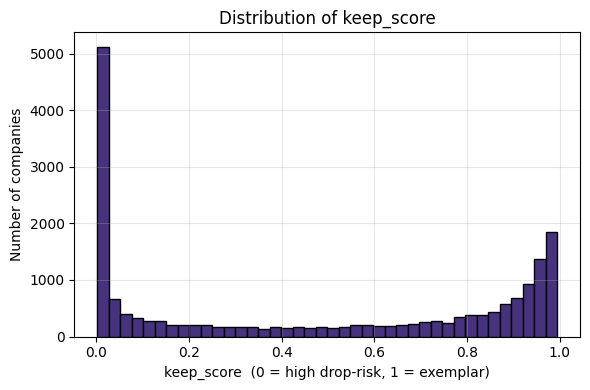


>>> CORRELATION with keep_score
keep_prob                  0.965
impact_area_governance     0.614
impact_area_workers        0.266
impact_area_environment    0.056
overall_score             -0.072
impact_area_customers     -0.321
impact_area_community     -0.356
Name: keep_score, dtype: float64


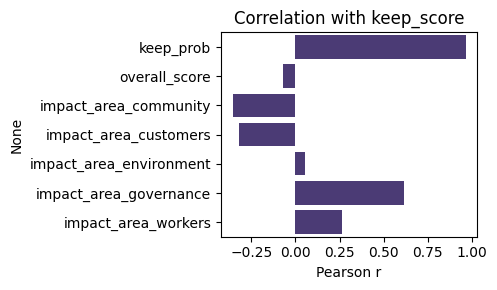

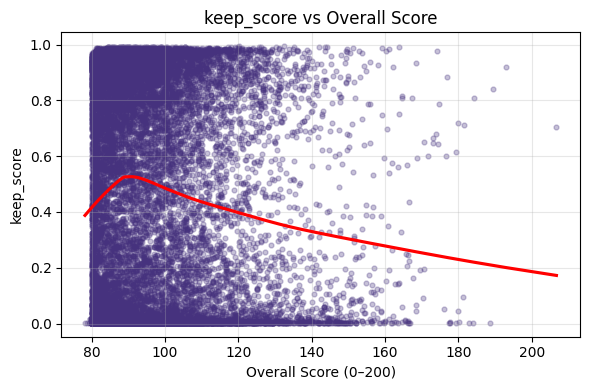

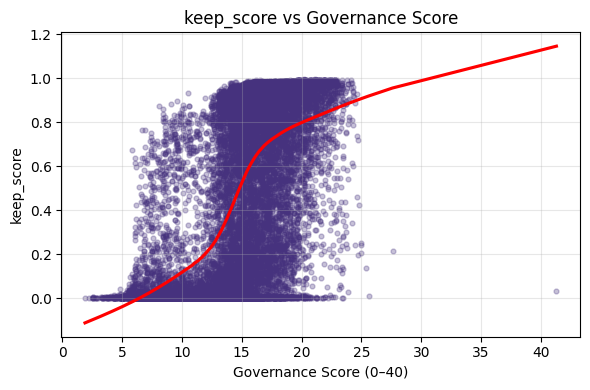


>>> GRADE DISTRIBUTION
bcorp_grade
Drop-risk     7886
Borderline    1609
Stable        2075
Exemplar      7174
Name: count, dtype: int64

>>> AVERAGE IMPACT SCORES BY GRADE
             overall_score  impact_area_community  impact_area_customers  \
bcorp_grade                                                                
Drop-risk            96.62                  29.97                  16.89   
Borderline           96.74                  25.45                  16.12   
Stable               95.90                  24.59                  12.62   
Exemplar             94.11                  19.92                   6.53   

             impact_area_environment  impact_area_governance  \
bcorp_grade                                                    
Drop-risk                      16.23                   12.02   
Borderline                     13.28                   15.53   
Stable                         14.95                   15.89   
Exemplar                       18.20             

/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_4906/47803622.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("bcorp_grade")[num_cols[2:]]   # 영역 점수만


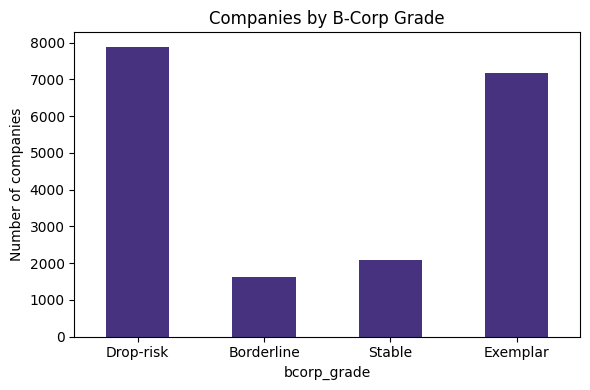


>>> TOP 10 EXEMPLAR COMPANIES
                       company_name  keep_score  overall_score  impact_area_governance  impact_area_workers
                           MAPP Ltd    0.994033          132.5                    21.1                 67.1
        Poynton Bradbury Architects    0.993808          120.3                    20.2                 60.6
                              ADLIB    0.992617          130.3                    21.8                 66.1
                 Magenta Associates    0.992543          126.1                    23.4                 64.9
                              Sopht    0.992184           94.6                    21.9                 33.8
Northtree Investment Management Ltd    0.992151          102.9                    22.8                 28.6
                    Calsoft Systems    0.991917          119.2                    21.1                 65.0
               Messerli Services SA    0.991839          102.7                    22.0                 46

In [74]:
# ─────────────────────────────────────────────────────────────
# 0. 패키지 준비  (필요 없으면 주석 처리)
# ─────────────────────────────────────────────────────────────
# !pip install pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")      # seaborn-style 겹침 방지
sns.set_palette("viridis")    # 색맹 안전 팔레트

# ─────────────────────────────────────────────────────────────
# 1. 데이터 불러오기
# ─────────────────────────────────────────────────────────────
PATH = "bc_continuous.csv"   # ♻︎ 경로 필요시 수정
df = pd.read_csv(PATH, low_memory=False)

# 예상 주요 열 이름
num_cols = [
    "keep_prob", "keep_score",
    "overall_score",
    "impact_area_community", "impact_area_customers",
    "impact_area_environment", "impact_area_governance",
    "impact_area_workers"
]

# ─────────────────────────────────────────────────────────────
# 2. 요약 통계 & 결측
# ─────────────────────────────────────────────────────────────
print("\n>>> BASIC SHAPE / NA")
print(df.shape)
print(df[num_cols].isna().sum())

print("\n>>> SUMMARY STATISTICS")
print(df[num_cols].describe().T.round(3))

# ─────────────────────────────────────────────────────────────
# 3. keep_score 분포 시각화
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.hist(df["keep_score"], bins=40, edgecolor="black")
plt.title("Distribution of keep_score")
plt.xlabel("keep_score  (0 = high drop-risk, 1 = exemplar)")
plt.ylabel("Number of companies")
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 4. 상관 행렬 (keep_score 기준)
# ─────────────────────────────────────────────────────────────
corr = df[num_cols].corr().loc["keep_score"].drop("keep_score")
print("\n>>> CORRELATION with keep_score")
print(corr.sort_values(ascending=False).round(3))

plt.figure(figsize=(5,3))
sns.barplot(x=corr.values, y=corr.index, orient="h")
plt.title("Correlation with keep_score")
plt.xlabel("Pearson r")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 5. 핵심 산점도 2종
# ─────────────────────────────────────────────────────────────
def scatter(x, y, xlabel, title):
    plt.figure(figsize=(6,4))
    plt.scatter(df[x], df[y], alpha=0.3, s=12)
    sns.regplot(x=df[x], y=df[y], scatter=False, color="red", lowess=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("keep_score")
    plt.grid(alpha=.3)
    plt.tight_layout()
    plt.show()

scatter("overall_score",  "keep_score",
        "Overall Score (0–200)", "keep_score vs Overall Score")

scatter("impact_area_governance", "keep_score",
        "Governance Score (0–40)", "keep_score vs Governance Score")

# ─────────────────────────────────────────────────────────────
# 6. 등급 라벨링 & 그룹 통계
# ─────────────────────────────────────────────────────────────
bins   = [0, 0.25, 0.5, 0.75, 1.01]
labels = ["Drop-risk", "Borderline", "Stable", "Exemplar"]
df["bcorp_grade"] = pd.cut(df["keep_score"], bins=bins, labels=labels, right=False)

grade_counts = df["bcorp_grade"].value_counts().loc[labels]
print("\n>>> GRADE DISTRIBUTION")
print(grade_counts)

grade_means = (
    df.groupby("bcorp_grade")[num_cols[2:]]   # 영역 점수만
      .mean()
      .loc[labels]
      .round(2)
)
print("\n>>> AVERAGE IMPACT SCORES BY GRADE")
print(grade_means)

plt.figure(figsize=(6,4))
grade_counts.plot(kind="bar")
plt.ylabel("Number of companies")
plt.title("Companies by B-Corp Grade")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 7. 상·하위 10개 기업 리스트 출력 (옵션)
# ─────────────────────────────────────────────────────────────
cols_to_show = ["company_name", "keep_score",
                "overall_score", "impact_area_governance",
                "impact_area_workers"]

top10 = df.nlargest(10, "keep_score")[cols_to_show]
bot10 = df.nsmallest(10, "keep_score")[cols_to_show]

print("\n>>> TOP 10 EXEMPLAR COMPANIES")
print(top10.to_string(index=False))

print("\n>>> BOTTOM 10 HIGH-RISK COMPANIES")
print(bot10.to_string(index=False))


In [75]:
!pip install statsmodels

# Exemplar 기업, Drop-Risk 기업에 대해 텍스트/네트워크 분석

In [76]:
import pandas as pd

# 1) 파일 로드
df = pd.read_csv("bc_continuous.csv")

# 2) Exemplar / Drop-Risk 라벨링
df["group"] = "Other"
df.loc[df["keep_prob"] >= 0.75, "group"] = "Exemplar"
df.loc[df["keep_prob"] < 0.25,  "group"] = "Drop-Risk"
results={}
subset = df[df["group"].isin(["Exemplar", "Drop-Risk"])].copy()

# 3) 비교할 컬럼 목록
cols = [
    "description",
    "industry",
    "industry_category",
    "products_and_services",
    "country",
    "state",
    "city",
    "sector",
    "size",
    "b_corp_profile",
    "website",
]

# 4) 요약표 생성 - 범주형은 빈도, 자유 텍스트는 단어 빈도
from collections import Counter
import re

for col in cols:
    if col not in subset.columns:
        print(f"Column {col} 없음"); continue
    
    if col in {"description", "products_and_services", "b_corp_profile"}:
        rows = []
        for grp in ["Exemplar", "Drop-Risk"]:
            txt = " ".join(subset.loc[subset["group"] == grp, col].dropna().astype(str))
            words = re.findall(r"\b[a-zA-Z]{3,}\b", txt.lower())
            for w, c in Counter(words).most_common(20):
                rows.append({"group": grp, "word": w, "count": c})
        df_words = pd.DataFrame(rows)
        results[col]= df_words
    else:
        counts = (
            subset.groupby(["group", col])
            .size()
            .reset_index(name="count")
            .sort_values(["group", "count"], ascending=[True, False])
            .groupby("group")
            .head(20)
            .reset_index(drop=True)
        )
        results[col]=counts


In [77]:
results

{'description':         group         word  count
 0    Exemplar          and  12751
 1    Exemplar          the   9472
 2    Exemplar         with   2959
 3    Exemplar          for   2825
 4    Exemplar          our   2814
 5    Exemplar         that   2256
 6    Exemplar        their   1904
 7    Exemplar          are   1751
 8    Exemplar         they   1269
 9    Exemplar       people    982
 10   Exemplar         from    908
 11   Exemplar     business    899
 12   Exemplar      company    855
 13   Exemplar          all    801
 14   Exemplar  sustainable    792
 15   Exemplar          its    790
 16   Exemplar         more    789
 17   Exemplar        world    780
 18   Exemplar          has    771
 19   Exemplar      through    722
 20  Drop-Risk          and  33320
 21  Drop-Risk          the  25676
 22  Drop-Risk          for   7420
 23  Drop-Risk        their   7057
 24  Drop-Risk         that   6996
 25  Drop-Risk         with   6889
 26  Drop-Risk         they   5417
 27  

In [78]:
import pandas as pd
import math
import re
from collections import Counter, defaultdict

# Load data
df = pd.read_csv("bc_continuous.csv")

# Label groups
df["group"] = "Other"
df.loc[df["keep_prob"] >= 0.75, "group"] = "Exemplar"
df.loc[df["keep_prob"] < 0.25, "group"] = "Drop-Risk"
subset = df[df["group"].isin(["Exemplar", "Drop-Risk"])]

# Choose the text column to analyse
text_col = "description"
results2={}
# Simple English stopword list
STOPWORDS = {
    "the","and","for","with","that","this","from","they","their","there","have","has","had",
    "are","were","was","been","being","our","your","will","would","could","should","shall",
    "may","might","can","cant","cannot","won","dont","does","did","doing","done","into","onto",
    "about","above","below","under","over","between","among","across","through","towards",
    "without","within","across","every","each","other","such","than","then","them","these",
    "those","into","out","also","more","most","many","some","any","all","one","two","three",
    "four","five","six","seven","eight","nine","ten","first","second","third","new","old",
    "company","business","impact","social","sustainable"  # domain-generic nouns to drop
}

# Tokenize and build document lists per group
docs_by_group = defaultdict(list)
for grp in ["Exemplar", "Drop-Risk"]:
    group_texts = subset.loc[subset["group"] == grp, text_col].dropna().astype(str)
    for doc in group_texts:
        tokens = re.findall(r'\b[a-zA-Z]{3,}\b', doc.lower())
        tokens = [t for t in tokens if t not in STOPWORDS]
        docs_by_group[grp].append(tokens)

# Calculate document frequencies across ALL documents
df_counts = Counter()
total_docs = 0
for docs in docs_by_group.values():
    total_docs += len(docs)
    for tokens in docs:
        df_counts.update(set(tokens))

# Pre-compute IDF
idf = {w: math.log((total_docs + 1) / (df_counts[w] + 1)) + 1 for w in df_counts}

# Compute BM25-like score per word for each group (aggregate)
k1 = 1.5
b = 0.75

def bm25_score(group_docs):
    # avg doc length in group
    avgdl = sum(len(d) for d in group_docs) / len(group_docs)
    tf = Counter()
    for tokens in group_docs:
        tf.update(tokens)
    scores = {}
    for word, freq in tf.items():
        idf_w = idf.get(word, 0)
        score = idf_w * (freq * (k1 + 1)) / (freq + k1 * (1 - b + b * (len(group_docs) / avgdl)))
        scores[word] = score
    return Counter(scores).most_common(30)

rows = []
for grp in ["Exemplar", "Drop-Risk"]:
    for word, score in bm25_score(docs_by_group[grp]):
        rows.append({"group": grp, "word": word, "bm25": round(score, 4)})

bm25_df = pd.DataFrame(rows)

bm25_df

,group,word,bm25
0,Exemplar,danone,11.1481
1,Exemplar,des,10.5036
2,Exemplar,les,10.2871
3,Exemplar,une,10.0013
4,Exemplar,dans,9.5141
5,Exemplar,pour,9.4984
6,Exemplar,est,9.4351
7,Exemplar,con,9.2398
8,Exemplar,travel,9.2289
9,Exemplar,que,9.1506


In [79]:
# 0) (한 번만) 필요한 라이브러리 설치
#    로컬 환경이라면 터미널이나 노트북 셀에서 실행
!pip install pandas langdetect googletrans==4.0.0-rc1

In [80]:
import pandas as pd
from langdetect import detect, LangDetectException
from googletrans import Translator
from concurrent.futures import ThreadPoolExecutor

df = pd.read_csv("bc_continuous.csv")

###############################################################################
# 1) 언어 감지 – ThreadPoolExecutor (GIL 영향 있지만 안정적)
###############################################################################
def detect_safe(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return "none"
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

with ThreadPoolExecutor(max_workers=32) as pool:          # 코어 수보다 크게 잡아도 OK
    df["lang"] = list(pool.map(detect_safe, df["description"].tolist()))

###############################################################################
# 2) 번역 – ThreadPoolExecutor (I/O bound)
###############################################################################
translator_kwargs = dict(raise_exception=True)            # 각 스레드에서 새 인스턴스

def translate_if_needed(idx, text, lang):
    if lang in ("en", "none", "unknown") or not isinstance(text, str) or not text.strip():
        return idx, text                                  # 그대로
    try:
        tr = Translator(**translator_kwargs)              # 스레드 로컬
        return idx, tr.translate(text, dest="en").text
    except Exception as e:
        print(f"[{idx}] 번역 실패: {e}")
        return idx, text                                  # 실패 시 원문

rows = [(i, df.at[i, "description"], df.at[i, "lang"]) 
        for i in df.index if df.at[i, "lang"] not in ("en", "none", "unknown")]

results = []
with ThreadPoolExecutor(max_workers=20) as pool:
    for idx, translated in pool.map(lambda args: translate_if_needed(*args), rows):
        results.append((idx, translated))

# 3) description_en 컬럼 구성
df["description_en"] = df["description"]          # 기본값: 원문
for idx, translated in results:                   # 번역된 것만 덮어쓰기
    df.at[idx, "description_en"] = translated

###############################################################################
# 4) 저장
###############################################################################
df.to_csv("non_english_descriptions_with_translation.csv", index=False)


In [81]:
non_en

import pandas as pd
import math
import re
from collections import Counter, defaultdict

# Load data
df = pd.read_csv("non_english_descriptions_with_translation.csv")

# Label groups
df["group"] = "Other"
df.loc[df["keep_prob"] >= 0.75, "group"] = "Exemplar"
df.loc[df["keep_prob"] < 0.25, "group"] = "Drop-Risk"
subset = df[df["group"].isin(["Exemplar", "Drop-Risk"])]

# Choose the text column to analyse
text_col = "description_en"
results2={}
# Simple English stopword list
STOPWORDS = {
    "the","and","for","with","that","this","from","they","their","there","have","has","had",
    "are","were","was","been","being","our","your","will","would","could","should","shall",
    "may","might","can","cant","cannot","won","dont","does","did","doing","done","into","onto",
    "about","above","below","under","over","between","among","across","through","towards",
    "without","within","across","every","each","other","such","than","then","them","these",
    "those","into","out","also","more","most","many","some","any","all","one","two","three",
    "four","five","six","seven","eight","nine","ten","first","second","third","new","old"
      # domain-generic nouns to drop
}

# Tokenize and build document lists per group
docs_by_group = defaultdict(list)
for grp in ["Exemplar", "Drop-Risk"]:
    group_texts = subset.loc[subset["group"] == grp, text_col].dropna().astype(str)
    for doc in group_texts:
        tokens = re.findall(r'\b[a-zA-Z]{3,}\b', doc.lower())
        tokens = [t for t in tokens if t not in STOPWORDS]
        docs_by_group[grp].append(tokens)

# Calculate document frequencies across ALL documents
df_counts = Counter()
total_docs = 0
for docs in docs_by_group.values():
    total_docs += len(docs)
    for tokens in docs:
        df_counts.update(set(tokens))

# Pre-compute IDF
idf = {w: math.log((total_docs + 1) / (df_counts[w] + 1)) + 1 for w in df_counts}

# Compute BM25-like score per word for each group (aggregate)
k1 = 1.5
b = 0.75

def bm25_score(group_docs):
    # avg doc length in group
    avgdl = sum(len(d) for d in group_docs) / len(group_docs)
    tf = Counter()
    for tokens in group_docs:
        tf.update(tokens)
    scores = {}
    for word, freq in tf.items():
        idf_w = idf.get(word, 0)
        score = idf_w * (freq * (k1 + 1)) / (freq + k1 * (1 - b + b * (len(group_docs) / avgdl)))
        scores[word] = score
    return Counter(scores).most_common(30)

rows = []
for grp in ["Exemplar", "Drop-Risk"]:
    for word, score in bm25_score(docs_by_group[grp]):
        rows.append({"group": grp, "word": word, "bm25": round(score, 4)})

bm25_df = pd.DataFrame(rows)

bm25_df

,group,word,bm25
0,Exemplar,danone,11.1714
1,Exemplar,travel,9.2633
2,Exemplar,london,8.9671
3,Exemplar,coffee,8.7721
4,Exemplar,wine,8.6728
5,Exemplar,nutrition,8.6248
6,Exemplar,recruitment,8.5741
7,Exemplar,data,8.4621
8,Exemplar,digital,8.4174
9,Exemplar,agency,8.3424


In [82]:
import pandas as pd, re, itertools
from collections import Counter


# ─────────────────── 설정 ───────────────────
CSV_PATH      = "bc_continuous.csv"
WINDOW_SIZE   = None        # 문장-유사 창(window) 크기, None=문서 전체
TOP_N_EDGES   = 200       # 보여줄 상위 엣지 수
TOP_N_NODES   = 200       # 중심성 상위 노드 수
STOPWORDS = {
    "the","and","for","with","that","this","from","they","their","there","have","has","had",
    "are","were","was","been","being","our","your","will","would","could","should","shall",
    "may","might","can","also","more","most","many","some","any","all","one","two","three",
    "other","such","into","onto","about","above","below","under","over","between","among",
    "across","through","towards","without","within","first","second","third","new","old"
}
# ────────────────────────────────────────────

# 1. 로드 및 라벨
df = pd.read_csv(CSV_PATH)
df["group"] = "Other"
df.loc[df["keep_prob"] >= 0.75, "group"] = "Exemplar"
df.loc[df["keep_prob"] < 0.25,  "group"] = "Drop-Risk"
subset = df[df["group"].isin(["Exemplar", "Drop-Risk"])]

# 2. 토큰화 함수
token_pat = re.compile(r"\b[a-zA-Z]{3,}\b")
def tokenize(txt: str):
    tokens = token_pat.findall(str(txt).lower())
    return [t for t in tokens if t not in STOPWORDS]

# 3. 하나의 문서에서 co-occurrence 생성
def doc_pairs(tokens, window=None):
    if not tokens:
        return []
    if window is None or window >= len(tokens):
        # 문서 전체 조합
        return [tuple(sorted(p)) for p in itertools.combinations(set(tokens), 2)]
    out = []
    for i in range(len(tokens) - window + 1):
        seg = set(tokens[i : i + window])
        out.extend(tuple(sorted(p)) for p in itertools.combinations(seg, 2))
    return out

# 4. 그룹별 엣지 빈도
edges_by_grp = {g: Counter() for g in ["Exemplar", "Drop-Risk"]}
for g in edges_by_grp:
    for doc in subset.loc[subset["group"] == g, "description"].dropna():
        edges_by_grp[g].update(doc_pairs(tokenize(doc), window=WINDOW_SIZE))

# 5-A. 상위 엣지 테이블 표시
for g, counter in edges_by_grp.items():
    edge_df = pd.DataFrame(
        [{"group": g, "word1": w1, "word2": w2, "weight": w}
         for (w1, w2), w in counter.most_common(TOP_N_EDGES)]
    )
    print(
        f"Top {TOP_N_EDGES} co-occurrence edges ({g})",
        edge_df
    )

# 5-B. 가중치 합(=degree centrality) 상위 노드
for g, counter in edges_by_grp.items():
    degree = Counter()
    for (a, b), w in counter.items():
        degree[a] += w
        degree[b] += w
    node_df = pd.DataFrame(
        [{"group": g, "word": w, "degree": deg}
         for w, deg in degree.most_common(TOP_N_NODES)]
    )
    print(
        f"Top {TOP_N_NODES} nodes by weighted degree ({g})",
        node_df
    )

# 6. (선택) networkx GEXF로 저장 → Gephi 사용

import networkx as nx, itertools
for g, counter in edges_by_grp.items():
    G = nx.Graph()
    for (a,b), w in counter.items():
        G.add_edge(a,b,weight=w)
    nx.write_gexf(G, f"cooc_{g}.gexf")



Top 200 co-occurrence edges (Exemplar)         group     word1        word2  weight
0    Exemplar    people       planet     272
1    Exemplar  business       people     253
2    Exemplar    people  sustainable     229
3    Exemplar    impact     positive     220
4    Exemplar    impact       people     213
..        ...       ...          ...     ...
195  Exemplar   company       create     101
196  Exemplar   founded        world     101
197  Exemplar      help        world     101
198  Exemplar    future       people     100
199  Exemplar   believe       people     100

[200 rows x 4 columns]
Top 200 co-occurrence edges (Drop-Risk)          group          word1        word2  weight
0    Drop-Risk       business       social     698
1    Drop-Risk         impact       social     697
2    Drop-Risk  environmental       social     663
3    Drop-Risk         change       social     655
4    Drop-Risk       business       change     647
..         ...            ...          ...     ...


In [83]:
edge_df.to_csv("edge_df.csv")
node_df.to_csv("node_df.csv")

In [84]:
df

,company_id,company_name,date_first_certified,date_certified,current_status,description,industry,industry_category,products_and_services,country,...,ia_workers_it_training_education,ia_workers_it_worker_benefits,ia_workers_it_worker_owned,ia_workers_it_worker_ownership,ia_workers_it_workforce_development,certification_cycle,is_active,keep_prob,keep_score,group
0,0013b00001rId9LAAS,Arch Textiles Manufacture Corp.,2021.2.24,2024-05-13,certified,"Established over a decade ago in Shanghai, Chi...",Textiles,Manufactured Goods,Textile Manufacturing,China,...,NaN,NaN,NaN,NaN,NaN,1,1,0.570346,0.699339,Other
1,0013b00001rId9LAAS,Arch Textiles Manufacture Corp.,2021.2.24,2021-02-24,certified,"Established over a decade ago in Shanghai, Chi...",Textiles,Manufactured Goods,Textile Manufacturing,China,...,NaN,NaN,NaN,NaN,NaN,2,0,0.462654,0.389800,Other
2,001C000001R0tn1IAB,kria,2016.6.29,2019-12-02,de-certified,Kria is a Brazilian equity crowdfunding platfo...,Other financial services,Financial & insurance activities,Online investment platform for startups - Plat...,Brazil,...,NaN,NaN,NaN,NaN,NaN,1,0,0.516625,0.549709,Other
3,001C000001R0tn1IAB,kria,2016.6.29,2016-06-29,de-certified,Kria is a Brazilian equity crowdfunding platfo...,Other financial services,Financial & insurance activities,Online investment platform for startups - Plat...,Brazil,...,3.8,6.0,NaN,6.0,NaN,2,0,0.612711,0.794542,Other
4,0013b00001zXx0fAAC,Ocean Design,2023.11.1,2023-11-07,certified,"Te oranga o te tāngata, he whenua, he moana.\n...",Advertising & market research,Professional & technical services,NaN,New Zealand,...,NaN,NaN,NaN,NaN,NaN,1,1,0.652458,0.861701,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18739,001C000001IDQCCIA5,Tricordant,2015.8.5,2017-10-03,certified,Tricordant work collaboratively with leaders t...,Management consultant - for-profits,Professional & technical services,Management Consultancy,United Kingdom,...,2.6,NaN,NaN,2.7,NaN,3,0,0.396452,0.223987,Other
18740,001C000001IDQCCIA5,Tricordant,2015.8.5,2015-08-05,certified,Tricordant work collaboratively with leaders t...,Management consultant - for-profits,Professional & technical services,Management Consultancy,United Kingdom,...,1.6,7.5,NaN,3.3,NaN,4,0,0.106513,0.008820,Drop-Risk
18741,0013b00001oo9XaAAI,NOMADS SURFING,2022.8.4,2022-08-04,de-certified,Nomads Surfing innovates every day to create s...,Sports goods,Retail,"Planches de surf éco-conçus, accessoires surf ...",France,...,NaN,NaN,NaN,NaN,NaN,1,0,0.530946,0.591787,Other
18742,001C000001kA42nIAC,Junction 37,2020.8.21,2023-09-25,certified,"Junction 37 was founded for a simple reason, t...",Advertising & market research,Professional & technical services,Media Buying and Consultancy Agency,United States,...,NaN,NaN,NaN,NaN,NaN,1,1,0.661878,0.874630,Other


In [85]:
df

,company_id,company_name,date_first_certified,date_certified,current_status,description,industry,industry_category,products_and_services,country,...,ia_workers_it_training_education,ia_workers_it_worker_benefits,ia_workers_it_worker_owned,ia_workers_it_worker_ownership,ia_workers_it_workforce_development,certification_cycle,is_active,keep_prob,keep_score,group
0,0013b00001rId9LAAS,Arch Textiles Manufacture Corp.,2021.2.24,2024-05-13,certified,"Established over a decade ago in Shanghai, Chi...",Textiles,Manufactured Goods,Textile Manufacturing,China,...,NaN,NaN,NaN,NaN,NaN,1,1,0.570346,0.699339,Other
1,0013b00001rId9LAAS,Arch Textiles Manufacture Corp.,2021.2.24,2021-02-24,certified,"Established over a decade ago in Shanghai, Chi...",Textiles,Manufactured Goods,Textile Manufacturing,China,...,NaN,NaN,NaN,NaN,NaN,2,0,0.462654,0.389800,Other
2,001C000001R0tn1IAB,kria,2016.6.29,2019-12-02,de-certified,Kria is a Brazilian equity crowdfunding platfo...,Other financial services,Financial & insurance activities,Online investment platform for startups - Plat...,Brazil,...,NaN,NaN,NaN,NaN,NaN,1,0,0.516625,0.549709,Other
3,001C000001R0tn1IAB,kria,2016.6.29,2016-06-29,de-certified,Kria is a Brazilian equity crowdfunding platfo...,Other financial services,Financial & insurance activities,Online investment platform for startups - Plat...,Brazil,...,3.8,6.0,NaN,6.0,NaN,2,0,0.612711,0.794542,Other
4,0013b00001zXx0fAAC,Ocean Design,2023.11.1,2023-11-07,certified,"Te oranga o te tāngata, he whenua, he moana.\n...",Advertising & market research,Professional & technical services,NaN,New Zealand,...,NaN,NaN,NaN,NaN,NaN,1,1,0.652458,0.861701,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18739,001C000001IDQCCIA5,Tricordant,2015.8.5,2017-10-03,certified,Tricordant work collaboratively with leaders t...,Management consultant - for-profits,Professional & technical services,Management Consultancy,United Kingdom,...,2.6,NaN,NaN,2.7,NaN,3,0,0.396452,0.223987,Other
18740,001C000001IDQCCIA5,Tricordant,2015.8.5,2015-08-05,certified,Tricordant work collaboratively with leaders t...,Management consultant - for-profits,Professional & technical services,Management Consultancy,United Kingdom,...,1.6,7.5,NaN,3.3,NaN,4,0,0.106513,0.008820,Drop-Risk
18741,0013b00001oo9XaAAI,NOMADS SURFING,2022.8.4,2022-08-04,de-certified,Nomads Surfing innovates every day to create s...,Sports goods,Retail,"Planches de surf éco-conçus, accessoires surf ...",France,...,NaN,NaN,NaN,NaN,NaN,1,0,0.530946,0.591787,Other
18742,001C000001kA42nIAC,Junction 37,2020.8.21,2023-09-25,certified,"Junction 37 was founded for a simple reason, t...",Advertising & market research,Professional & technical services,Media Buying and Consultancy Agency,United States,...,NaN,NaN,NaN,NaN,NaN,1,1,0.661878,0.874630,Other
